In [1]:
import jax.numpy as jnp
import numpy as onp

from ml_tools.jax_kernels import ard_rbf_kernel_efficient

In [2]:
# Let's make a really simple example.
onp.random.seed(2)
x = onp.random.uniform(-2, 2, size=100).reshape(-1, 1)

In [3]:
lscale = onp.reshape(onp.random.uniform(1, 5), (1,))
alpha = 1.

k_true = ard_rbf_kernel_efficient(x, x, alpha, lscale, jitter=0)

/anaconda2/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
draw = onp.random.multivariate_normal(onp.zeros(x.shape[0]), k_true)

/anaconda2/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

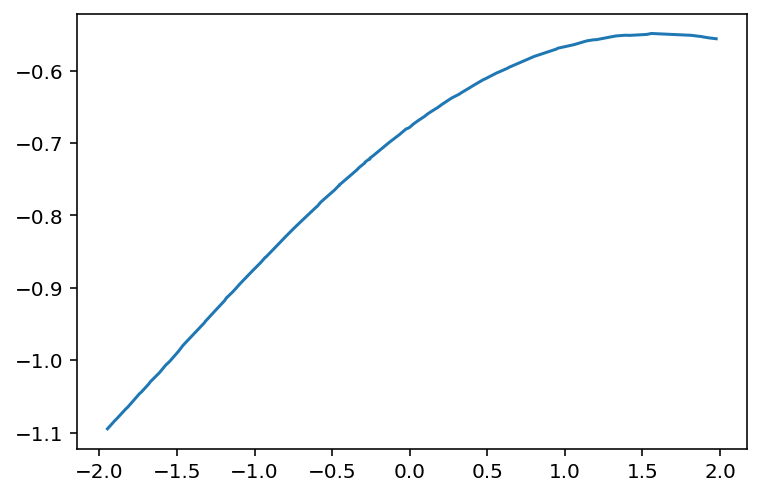

In [6]:
order = onp.argsort(x[:, 0])

plt.plot(x[order], draw[order])

In [7]:
from scipy.stats import norm

# Draw some data
probs = norm.cdf(draw)

In [8]:
y = onp.random.binomial(1, probs)

In [9]:
# Great. I have my input data x, and my outcomes y.

In [10]:
# I'm going to start with 10 inducing points.

In [11]:
m = jnp.zeros(10)
L = jnp.zeros((10, 10))

In [12]:
indices = jnp.tril_indices(L.shape[0])
num_indices = indices[0].shape[0]

In [13]:
random_vals = onp.random.randn(num_indices)

In [14]:
from jax.ops.scatter import index_update

In [15]:
L = index_update(L, indices, random_vals)

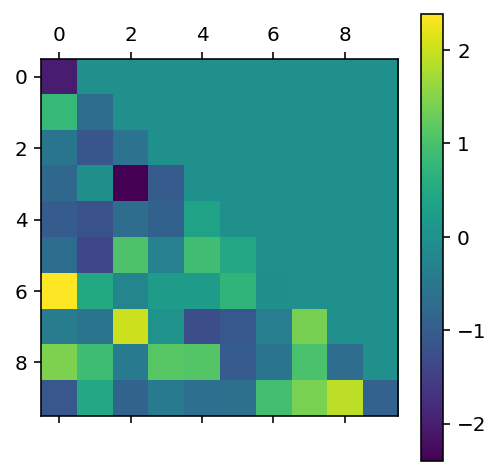

In [16]:
plt.matshow(L)
plt.colorbar()

In [17]:
Z = onp.random.uniform(-2, 2, 10).reshape(-1, 1)

In [18]:
from scipy.integrate import quad

In [19]:
# Grab only some points
batch_size = 5

In [20]:
chosen = onp.random.choice(x.shape[0], size=batch_size, replace=False)

In [21]:
x_batch = x[chosen]
y_batch = y[chosen]

In [22]:
from functools import partial
opt_alpha = 1.2
opt_lscale = jnp.array([1.])

cur_kern = partial(ard_rbf_kernel_efficient, alpha=opt_alpha, rho=opt_lscale,
                   jitter=0)

knm = cur_kern(x_batch, Z)
kmm = cur_kern(Z, Z)
knn = cur_kern(x_batch, x_batch)

# TODO: Of course I don't really want to invert this like this!
# But just for ease of reproducing the paper.
A = knm @ jnp.linalg.inv(kmm)

mean = A @ m

S = L @ L.T
cov = knn + A @ (S - kmm) @ A.T


In [23]:
mean

DeviceArray([0., 0., 0., 0., 0.], dtype=float32)

In [25]:
margin_vars = jnp.diag(cov)

In [60]:
@jit
def log_y_f(y, f):
    
    return y * norm.logcdf(f) + (1 - y) * norm.logcdf(-f)

In [61]:
from jax.scipy.stats import norm
from scipy.stats import norm as spnorm
from jax import jit
from jax import vmap

# Check out quadrature
@jit
def to_quadrature(f, cur_y, cur_mean, cur_var):
    
    log_prob = log_y_f(cur_y, f)
    q = norm.pdf(f, cur_mean, jnp.sqrt(cur_var))
    
    return log_prob * q

In [62]:
from scipy.integrate import quad

In [63]:
results = onp.zeros(batch_size)

for i, (cur_y, cur_mean, cur_var) in enumerate(zip(y_batch, mean, margin_vars)):

    curried_integrand = partial(
        to_quadrature, cur_y=cur_y, 
        cur_mean=cur_mean, cur_var=cur_var)

    quad_result = quad(curried_integrand, -jnp.inf, jnp.inf)
    results[i] = quad_result[0]
    
    print(i, quad_result)

0 (-12.848177332727728, 1.9113347882182552e-07)


/anaconda2/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


1 (-8814.270325829082, 0.0006609098885252348)
2 (-12.630509014225867, 3.1231173025503267e-07)
3 (-182.5046041055511, 2.1884321229685317e-06)
4 (-26.7269719438269, 6.97371903117802e-07)


In [65]:
from jax import grad

In [73]:
grad_f = grad(log_y_f, 1)
hess_f = grad(grad(log_y_f, 1), 1)

@jit
def to_quad_mu(f, cur_y, cur_mean, cur_var):
    
    in_exp = grad_f(cur_y, f)
    to_mult = norm.pdf(f, cur_mean, jnp.sqrt(cur_var))
    
    return in_exp * to_mult

@jit
def to_quad_var(f, cur_y, cur_mean, cur_var):
    
    in_exp = hess_f(cur_y, f)
    to_mult = norm.pdf(f, cur_mean, jnp.sqrt(cur_var))
    
    return 0.5 * in_exp * to_mult

In [74]:
curried_integrand_grad_mu = partial(
    to_quad_mu, cur_y=cur_y, 
    cur_mean=cur_mean, cur_var=cur_var)

quad_result = quad(curried_integrand_grad_mu, -jnp.inf, jnp.inf)

/anaconda2/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """


In [72]:
quad_result

(-4.147739072992216, 3.307789930964786e-05)

In [75]:
curried_integrand_grad_var = partial(
    to_quad_var, cur_y=cur_y, 
    cur_mean=cur_mean, cur_var=cur_var)

quad_result = quad(curried_integrand_grad_var, -jnp.inf, jnp.inf)

/anaconda2/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """


In [76]:
quad_result

(-0.25207636422591173, 0.0005639746417389394)

In [78]:
# Next steps would be:
# 1. Map gradients w.r.t. mu, sigma sq back to gradients on L and so on (with chain rule I guess)
# 2. Optimise w.r.t. those parameters.
# 3. Replace this quadrature routine with a better one. See how hard Gauss-Hermite is.
# (3): It actually looks quite easy. You just need to change variables and do a bunch of stuff.
# See: https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature

In [88]:
x_quad, w_quad = onp.polynomial.hermite.hermgauss(100)
# This looks promising but I think the weight function here is a
# standard normal
def transform_x(x, sigma, mu):
    return jnp.sqrt(2) * sigma * x + mu

In [89]:
x_to_eval = transform_x(x_quad, jnp.sqrt(cur_var), cur_mean)

In [90]:
jnp.sum(w_quad * log_y_f(cur_y, x_to_eval)) / jnp.sqrt(jnp.pi)

DeviceArray(-26.727625, dtype=float32)

In [91]:
# Wow you are kidding me. It's that easy?!

In [92]:
# We could probably even just backprop through that calculation, no?

In [97]:
@jit
def expectation(cur_y, cur_var, cur_mean):
    
    x_to_eval = transform_x(x_quad, jnp.sqrt(cur_var), cur_mean)
    return jnp.sum(w_quad * log_y_f(cur_y, x_to_eval)) / jnp.sqrt(jnp.pi)

In [99]:
grad(expectation, 1)(cur_y, cur_var, cur_mean)

DeviceArray(-0.25208643, dtype=float32)

In [101]:
grad(expectation, 2)(cur_y, cur_var, cur_mean)

DeviceArray(-4.1466317, dtype=float32)

In [102]:
# So that just works. My god. This is epic.

In [ ]:
# OK so since this works, the process of fitting this model
# should actually be pretty straightforward.
# Just write a function that takes in the elements for L, m, and all the rest
# Then get its gradient
# Optimise as usual.
# Should be pretty easy in Jax.